In [16]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

TAR_PATH = "/home/yifan/Exp/Noise/0.1/experiment_3"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis2'

DEVICE='cuda:1'
########## initulize reference data and target data
from AlignVis.DataInit import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
tar_datainit = DataInit(TAR_PATH,TAR_PATH,TAR_EPOCH,DEVICE)
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH,DEVICE)

ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from AlignVis.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from AlignVis_Visualizer.visualizer import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 1255.37it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 993.33it/s]


absolute alignment indicates number: 0 label diff indicates number: 5832 confidence diff indicates number: 530 high distance number: 6378


In [27]:
from AlignVis.autoencoder_generator import AutoEncoderGenerator
AutoEncoder_Generator = AutoEncoderGenerator(REF_PATH, REF_PATH, TAR_PATH, TAR_PATH, 200,200, projector, DEVICE)
import os
if os.path.exists(os.path.join(TAR_PATH, "pre_autoencoder.npy")):
    print("continue")
    autoencoder = AutoEncoder_Generator.encoder_trainer_with_pre_trained(os.path.join(TAR_PATH, "pre_autoencoder.npy"), os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=500,num_epochs=10,learning_rate=1e-2)
else:
    print("new one")
    autoencoder = AutoEncoder_Generator.encoder_trainer(os.path.join(TAR_PATH, "pre_autoencoder.npy"),batch_size=500,num_epochs=5,learning_rate=1e-2)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7419.24it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6221.60it/s]


continue
NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6308.36it/s]


NET resnet18
Finish initialization...


100%|██████████| 3/3 [00:00<00:00, 7384.34it/s]


KeyboardInterrupt: 

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7944.78it/s]


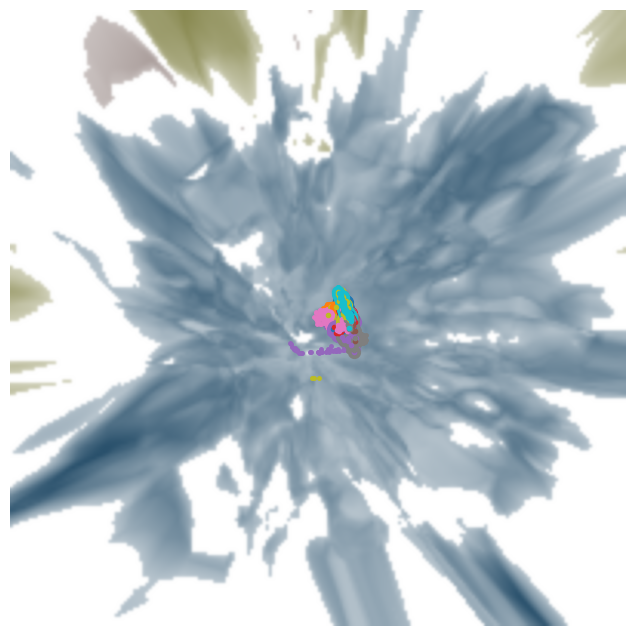

In [26]:
##### visuallize all data
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
VIS_MODEL_NAME = 'vis'
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
Y = torch.Tensor(tar_provider.train_representation(TAR_EPOCH))
encoded_Y = autoencoder.encoder(Y)
I = np.eye(512)
from AlignVis_Visualizer.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, ref_provider, autoencoder, np.dot(encoded_Y.detach().numpy(), I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(REF_EPOCH, path=os.path.join(TAR_PATH, "vis.png"))

In [3]:
from AlignVis_eval.AlignEval import Evaluator
eval = Evaluator(projector,ref_provider,tar_provider,REF_EPOCH,TAR_EPOCH)
# eval.eval_boundary_nn_autoencoder(tar_border_centers, autoencoder)

In [19]:
eval.eval_nn_train_autoencoder(15,autoencoder)

Fri May 12 13:00:53 2023 Building RP forest with 16 trees
Fri May 12 13:00:54 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Fri May 12 13:00:55 2023 Building RP forest with 16 trees
Fri May 12 13:00:56 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving for autoencoder: 1.03/15 in epoch 200


1.03154

In [5]:
eval.eval_ppr_autoencoder(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8348.54it/s]

#train# autoencoder PPR: 0.91 in epoch 200


0.91206

In [28]:

####### generate boundary ponits for tar and ref respectively
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,REF_PATH,TAR_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_boundary,tar_boundary = BoundaryGen.get_boundary_point(DEVICE,num_adv_eg=2000)
import torch
###### get border sample features
import torch.nn as nn

ref_feature_model = ref_model.to(DEVICE)
ref_feature_model = nn.Sequential(*list(ref_feature_model.children())[:-1])
with torch.no_grad():
    features = ref_feature_model(ref_boundary)
    ref_features = features.view(ref_boundary.shape[0], -1).cpu().numpy()

###### get border sample features
tar_feature_model = tar_model.to(DEVICE)
tar_feature_model = nn.Sequential(*list(tar_feature_model.children())[:-1])
with torch.no_grad():
    tar_features = tar_feature_model(tar_boundary)
    tar_features = tar_features.view(tar_boundary.shape[0], -1).cpu().numpy()

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 5844.45it/s]


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6403.83it/s]


RuntimeError: CUDA out of memory. Tried to allocate 586.00 MiB (GPU 1; 14.75 GiB total capacity; 1.62 GiB already allocated; 523.94 MiB free; 2.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 0.34/15 in epoch 200


0.33634

In [23]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [9]:
eval.eval_boundary_nn_autoencoder(tar_features, autoencoder)

#train# boundary preserving: 1.39/15 in epoch 200


1.39292

In [22]:
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
encoded_Y = autoencoder.encoder(torch.Tensor(tar_train_data))
encoded_Y = encoded_Y.detach().numpy()
# indicates = np.random.choice(aligned, size=10, replace=False)
indicates = np.random.choice(np.arange(5000), size=1000, replace=False)
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(tar_train_data[indicates],encoded_Y[indicates]))

CKA between absolute alignmnet subset is: 0.9390302691060002


In [12]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 3897.99it/s]


long distance move subet number is 2987, short distance move set number is 667


100%|██████████| 250/250 [00:00<00:00, 4148.13it/s]


all reference distance preserving 49919/50000
all target distance preserving 46700/50000
short distance move direction preserving 615/667
long distance move direction preserving 2771/2987


In [13]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 4164.45it/s]

refere  predction preserving:49140/50000 0.98
target  predction preserving:45603/50000 0.91
ref&tar pred_same preserving:45085/49900 0.90
ref&tar pred_diff preserving:53/100 0.53


In [36]:
from AlignVis.AlignmentBoundaryGenerator import AlignmentBoundaryGenerator
BoundaryGen = AlignmentBoundaryGenerator(REF_PATH,TAR_PATH,REF_PATH,TAR_PATH,REF_EPOCH,TAR_EPOCH,DEVICE)
ref_b_features,tar_b_features = BoundaryGen.get_boundary_features(DEVICE,num_adv_eg=1000)

NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 761.86it/s] 


NET resnet18
Finish initialization...


 23%|██▎       | 58/250 [00:31<01:43,  1.86it/s]


KeyboardInterrupt: 

In [15]:
import os
location_R = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_ref_border.npy")
location_T = os.path.join(TAR_PATH, "Model","Epoch_{:d}".format(TAR_EPOCH), "aligned_tar_border.npy")
np.save(location_R, ref_features)
np.save(location_T, tar_features)

In [9]:
ref_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_ref_border.npy")
ref_b_features = np.load(ref_border_centers_loc).squeeze()

In [10]:
tar_border_centers_loc = os.path.join(TAR_PATH,"Model", "Epoch_{:d}".format(TAR_EPOCH),
                                          "aligned_tar_border.npy")
tar_b_features = np.load(tar_border_centers_loc).squeeze()

In [21]:
eval.eval_boundary_nn_ref_in_ref(ref_features)

#train# boundary preserving: 1.41/15 in epoch 200


1.4059

In [28]:
eval.eval_boundary_nn_autoencoder(tar_b_features,autoencoder,15)

#train# boundary preserving: 0.13/15 in epoch 200


0.13102

In [24]:
def eval_boundary_align_sensitivity(autoencoder, tar_b_features, ref_b_features):
        ############## init ###################
        #init target
        print("123")
        tar_b_pred = tar_provider.get_pred(TAR_EPOCH, tar_b_features)
        tar_b_pred = tar_b_pred + 1e-8
        tar_sort_preds = np.sort(tar_b_pred, axis=1)
        tar_diff = (tar_sort_preds[:, -1] - tar_sort_preds[:, -2]) / (tar_sort_preds[:, -1] - tar_sort_preds[:, 0])
        tar_border = np.zeros(len(tar_diff), dtype=np.uint8) + 0.05
        tar_border[tar_diff < 0.15] = 1

        #init reference
        ref_b_pred = ref_provider.get_pred(REF_EPOCH, ref_b_features)
        ref_b_pred = ref_b_pred + 1e-8
        ref_sort_preds = np.sort(ref_b_pred, axis=1)
        ref_diff = (ref_sort_preds[:, -1] - ref_sort_preds[:, -2]) / (ref_sort_preds[:, -1] - ref_sort_preds[:, 0])
        ref_border = np.zeros(len(ref_diff), dtype=np.uint8) + 0.05
        ref_border[ref_diff < 0.15] = 1
        
        ##### get all boundary list
        all_boundary_list = []
        
        for i in range(len(ref_border)):
            if ref_border[i] == 1 and tar_border[i] == 1:
                all_boundary_list.append(i)
        print(len(all_boundary_list))
        #### get ref low dimensional border
        ref_b_embedding = projector.batch_project(REF_EPOCH, ref_b_features)
        ref_b_inv = projector.batch_inverse(REF_EPOCH,ref_b_embedding)
        ref_b_pred_l = ref_provider.get_pred(REF_EPOCH, ref_b_inv)
        ref_b_pred_l = ref_b_pred_l  + 1e-8
        ref_sort_preds_l  = np.sort(ref_b_pred_l , axis=1)
        ref_diff_l  = (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, -2]) / (ref_sort_preds_l[:, -1] - ref_sort_preds_l[:, 0])
        ref_border_l = np.zeros(len(ref_diff_l), dtype=np.uint8) + 0.05
        ref_border_l[ref_diff_l < 0.15] = 1
        
        #### get target low dimensional border
        tar_b_embedding = projector.batch_project(REF_EPOCH, autoencoder.encoder(torch.Tensor(ref_b_features)).detach().numpy())
        tar_b_inv = projector.batch_inverse(REF_EPOCH,tar_b_embedding)
        tar_b_inv = autoencoder.decoder(torch.Tensor(tar_b_inv)).detach().numpy()
        tar_b_pred_l = tar_provider.get_pred(REF_EPOCH, tar_b_inv)
        tar_b_pred_l = tar_b_pred_l  + 1e-8
        tar_sort_preds_l  = np.sort(tar_b_pred_l , axis=1)
        tar_diff_l  = (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, -2]) / (tar_sort_preds_l[:, -1] - tar_sort_preds_l[:, 0])
        tar_border_l = np.zeros(len(tar_diff_l), dtype=np.uint8) + 0.05
        tar_border_l[tar_diff_l < 0.15] = 1

        all_boundary_list_l = []
       
        all_change = []
        all_change_l=[]
      
        for i in range(len(ref_border)):
          ##### low dimension all border
            if ref_border_l[i] == 1 and tar_border_l[i] == 1:
                all_boundary_list_l.append(i)
            if ref_border[i] != tar_border[i]:
                 all_change.append(i)
            if ref_border[i] != tar_border[i] and tar_border_l[i] == tar_border[i]:
                 all_change_l.append(i)
                 
                 
           


        print("boundary sample preserving{}/{}".format(len(all_boundary_list_l),len(all_boundary_list)))
        print("boundary change preserving{}/{}".format(len(all_change_l),len(all_change)))
       
eval_boundary_align_sensitivity(autoencoder,np.concatenate((tar_train_data,tar_features),axis=0), np.concatenate((ref_train_data,ref_features),axis=0))       

123


100%|██████████| 260/260 [00:00<00:00, 6133.20it/s]

839



100%|██████████| 260/260 [00:00<00:00, 8216.32it/s]

boundary sample preserving0/839
boundary change preserving1461/8623


In [22]:
eval.eval_move_direction_preserving(autoencoder,10,1.5)

100%|██████████| 250/250 [00:00<00:00, 8530.35it/s]


long distance move subet number is 2716, short distance move set number is 715


100%|██████████| 250/250 [00:00<00:00, 8533.06it/s]


all reference distance preserving 49409/50000
all target distance preserving 49196/50000
short distance move direction preserving 692/715
long distance move direction preserving 2644/2716


In [23]:
val_same, val_diff = eval.eval_prediction_preserving(autoencoder)

100%|██████████| 250/250 [00:00<00:00, 8388.34it/s]

refere  predction preserving:46512/50000 0.93
target  predction preserving:44579/50000 0.89
ref&tar pred_same preserving:42880/49902 0.86
ref&tar pred_diff preserving:43/98 0.44
